# Privacy Analysis

The dataset (named Internet Privacy Poll) was gathered from [here](https://www.pewresearch.org/internet/2013/09/05/anonymity-privacy-and-security-online/).

There is a full report on it [here](https://www.pewresearch.org/internet/wp-content/uploads/sites/9/media/Files/Reports/2013/PIP_AnonymityOnline_090513.pdf).

For this work we are using a simplified version available [here](https://www.kaggle.com/datasets/econdata/internet-privacy-poll/data).

## Internet Privacy Poll

Internet privacy has gained widespread attention in recent years. To measure the degree to which people are concerned about hot-button issues like Internet privacy, social scientists conduct polls in which they interview a large number of people about the topic. In this assignment, we will analyze data from a July 2013 Pew Internet and American Life Project poll on Internet anonymity and privacy, which involved interviews across the United States. While the full polling data can be found on the Pew Research Center’s website, we will use a more limited version of the results, available in AnonymityPoll (CSV). The dataset has the following fields (all Internet use-related fields were only collected from interviewees who either use the Internet or have a smartphone):

- Internet.Use: A binary variable indicating if the interviewee uses the Internet, at least occasionally (equals 1 if the interviewee uses the Internet, and equals 0 if the interviewee does not use the Internet).
- Smartphone: A binary variable indicating if the interviewee has a smartphone (equals 1 if they do have a smartphone, and equals 0 if they don’t have a smartphone).
- Sex: Male or Female.
- Age: Age in years.
- State: State of residence of the interviewee.
- Region: Census region of the interviewee (Midwest, Northeast, South, or West).
- Conservativeness: Self-described level of conservativeness of interviewee, from 1 (very liberal) to 5 (very conservative).
- Info.On.Internet: Number of the following items this interviewee believes to be available on the Internet for others to see: 
    1. Their email address; 
    2. Their home address; 
    3. Their home phone number; 
    4. Their cell phone number;
    5. The employer/company they work for;
    6. Their political party or political affiliation;
    7. Things they’ve written that have their name on it;
    8. A photo of them;
    9. A video of them;
    10. Which groups or organizations they belong to; and
    11. Their birth date.
- Worry.About.Info: A binary variable indicating if the interviewee worries about how much information is available about them on the Internet (equals 1 if they worry, and equals 0 if they don’t worry).
- Privacy.Importance: A score from 0 (privacy is not too important) to 100 (privacy is very important), which combines the degree to which they find privacy important in the following: (1) The websites they browse; (2) Knowledge of the place they are located when they use the Internet; (3) The content and files they download; (4) The times of day they are online; (5) The applications or programs they use; (6) The searches they perform; (7) The content of their email; (8) The people they exchange email with; and (9) The content of their online chats or hangouts with others.
- Anonymity.Possible: A binary variable indicating if the interviewee thinks it’s possible to use the Internet anonymously, meaning in such a way that online activities can’t be traced back to them (equals 1 if he/she believes you can, and equals 0 if he/she believes you can’t).
- Tried.Masking.Identity: A binary variable indicating if the interviewee has ever tried to mask his/her identity when using the Internet (equals 1 if he/she has tried to mask his/her identity, and equals 0 if he/she has not tried to mask his/her identity).
- Privacy.Laws.Effective: A binary variable indicating if the interviewee believes United States law provides reasonable privacy protection for Internet users (equals 1 if he/she believes it does, and equals 0 if he/she believes it doesn’t).


In [1]:
%matplotlib inline

import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

import pynnmf.pynnmf as pynnmf

import sklearn.metrics as metrics
import sklearn.model_selection as model_selection

sns.set_theme()
plt.style.use('tableau-colorblind10')
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['lines.linewidth'] = 2

## Load the Dataset

In [2]:
df = pl.read_csv('AnonymityPoll.csv', null_values=['NA'])
df.head()

Internet,Smartphone,Sex,Age,State,Region,Conservativeness,Info on Internet,Worry about Info,Privacy Importance,Anonymity Possible,Tried Masking Identity,Privacy Laws Effective
i64,i64,str,i64,str,str,i64,i64,i64,f64,i64,i64,i64
1,0,"""Male""",62,"""Massachusetts""","""Northeast""",4,0,1,100.0,0,0,0
1,0,"""Male""",45,"""South Carolina""","""South""",1,1,0,0.0,1,0,1
0,1,"""Female""",70,"""New Jersey""","""Northeast""",4,0,0,null,0,0,null
1,0,"""Male""",70,"""Georgia""","""South""",4,3,1,88.888889,1,0,0
0,null,"""Female""",80,"""Georgia""","""South""",4,null,null,null,null,null,null


In [3]:
df.describe()

statistic,Internet,Smartphone,Sex,Age,State,Region,Conservativeness,Info on Internet,Worry about Info,Privacy Importance,Anonymity Possible,Tried Masking Identity,Privacy Laws Effective
str,f64,f64,str,f64,str,str,f64,f64,f64,f64,f64,f64,f64
"""count""",1001.0,959.0,"""1002""",975.0,"""1002""","""1002""",940.0,792.0,790.0,787.0,753.0,784.0,894.0
"""null_count""",1.0,43.0,"""0""",27.0,"""0""","""0""",62.0,210.0,212.0,215.0,249.0,218.0,108.0
"""mean""",0.774226,0.507821,null,52.370256,null,null,3.276596,3.795455,0.488608,62.848672,0.36919,0.163265,0.261745
"""std""",0.4183,0.5002,null,18.597082,null,null,1.012218,2.699174,0.500187,31.472764,0.482906,0.369844,0.439831
"""min""",0.0,0.0,"""Female""",18.0,"""Alabama""","""Midwest""",1.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",1.0,0.0,null,37.0,null,null,3.0,2.0,0.0,42.857143,0.0,0.0,0.0
"""50%""",1.0,1.0,null,55.0,null,null,3.0,4.0,0.0,68.75,0.0,0.0,0.0
"""75%""",1.0,1.0,null,66.0,null,null,4.0,6.0,1.0,88.888889,1.0,0.0,1.0
"""max""",1.0,1.0,"""Male""",96.0,"""Wyoming""","""West""",5.0,11.0,1.0,100.0,1.0,1.0,1.0


### Auxiliary functions

In [4]:
def round_matrix(Xr, t=0.5):
    # Clip the numerial columns
    Xr2 = Xr.copy()
    Xr2[:,3] = np.clip(Xr2[:,2], 0.0, 1.0)
    Xr2[:,3] = np.clip(Xr2[:,4], 0.0, 1.0)
    Xrt = Xr2.T
    
    # Round the binary columns
    for i in [0,1,3,5,6,7]:
        Xrt[i][Xrt[i] >  t] = 1
        Xrt[i][Xrt[i] <= t] = 0
    Xr2 = Xrt.T

    return Xr2

def adjusted_cost_matrix(Xr, X, M, t=0.5):
    # Compute the RMSE cost after cleaning the matrix
    Xr2 = round_matrix(Xr, t)
    rmse_cost = np.linalg.norm((Xr2[M]) - (X[M])) / np.sqrt(len(X[M]))
    return rmse_cost

def fill_in_missing_values(df):
    # Fill in missing values
    df = df.with_columns(pl.col('Age').fill_null(pl.col('Age').median()),
    pl.col('Conservativeness').fill_null(pl.col('Conservativeness').median()))

    # Scaling the features
    df = df.with_columns((pl.col('Privacy Importance')-pl.min('Privacy Importance'))/(pl.max('Privacy Importance')-pl.min('Privacy Importance')))
    df = df.with_columns((pl.col('Info on Internet')-pl.min('Info on Internet'))/(pl.max('Info on Internet')-pl.min('Info on Internet')))
    df1 = df[['Sex', 'Age', 'State', 'Region', 'Conservativeness']]

    # Matrix with the values to predict
    X = df[['Internet', 'Smartphone', 'Info on Internet', 'Worry about Info', 'Privacy Importance',
    'Anonymity Possible', 'Tried Masking Identity', 'Privacy Laws Effective']].to_numpy()
    # Mas for the missing values
    M = np.isnan(X)

    # Grid Search
    ts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    ks = [2,3,4,5,6,7,8]
    seeds = [3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 17]

    # Store best solution (min cost)
    min_cost = float('inf')
    solution = None

    for t in ts:
        for k in ks:
            for s in seeds:
                Xr, _, _, _ = pynnmf.nmf_mu(X, k=k, seed=s)
                adjusted_cost = adjusted_cost_matrix(Xr, X, ~M, t)
                if adjusted_cost < min_cost:
                    min_cost = adjusted_cost
                    solution = (t, k, s)

    print(f'{min_cost} / {solution}')

    # Compute the best reconstruction
    t, k, s = solution
    Xr, _, _, _ = pynnmf.nmf_mu(X, k=k, seed=s)
    Xr2 = round_matrix(Xr, t=t)

    # Replace NAN with predicted values
    X[M] = Xr2[M]
    
    # Merege the two dataframes
    df2 = pl.from_numpy(X, schema=['Internet', 'Smartphone', 'Info on Internet', 'Worry about Info', 'Privacy Importance',
    'Anonymity Possible', 'Tried Masking Identity', 'Privacy Laws Effective'])
    
    df_final = pl.concat([df1, df2], how='horizontal')
    
    return df_final

def train_test_split_regression(X, y, test_size=0.2, b='auto', random_state=42):
    #print(f'y = {y}')
    if isinstance(b, str):
        bins = np.histogram_bin_edges(y, bins=b)
        # remove the last index (end point)
        bins = bins[:-1]
    elif isinstance(b, int):
        bins = np.linspace(min(y), max(y), num=b, endpoint=False)
    else:
        raise Exception(f'Undefined bins {b}')
        
    #print(f'Bins: {bins}')
    groups = np.digitize(y, bins)
    #print(f'Group: {groups}')
    return model_selection.train_test_split(X, y, test_size=test_size, stratify=groups, random_state=random_state)

def create_folds_regression(X, y, b='auto', k=3):
    if isinstance(b, str):
        bins = np.histogram_bin_edges(y, bins=b)
        # remove the last index (end point)
        bins = bins[:-1]
    elif isinstance(b, int):
        bins = np.linspace(min(y), max(y), num=b, endpoint=False)
    else:
        raise Exception(f'Undefined bins {b}')
        
    #print(f'Bins: {bins}')
    groups = np.digitize(y, bins)
    #print(f'Group: {groups}')
    skf = model_selection.StratifiedKFold(n_splits=k)
    return skf.split(X, groups)

def smape(A, F):
    tmp = 2 * np.abs(F - A) / (np.abs(A) + np.abs(F))
    len_ = np.count_nonzero(~np.isnan(tmp))
    if len_ == 0 and np.nansum(tmp) == 0: # Deals with a special case
        return 100
    return 100 / len_ * np.nansum(tmp)

def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print(f'EV   : {round(explained_variance,4)}')    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print(f'R2   : {round(r2,4)}')
    print(f'MAE  : {round(mean_absolute_error,4)}')
    print(f'MSE  : {round(mse,4)}')
    print(f'RMSE : {round(np.sqrt(mse),4)}')
    print(f'SMAPE: {round(smape(y_true, y_pred),4)}')

## Basic Analysis

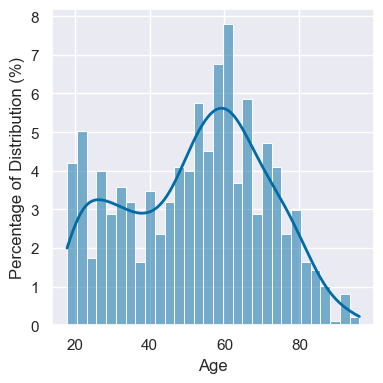

In [5]:
# age distribution
ax = sns.histplot(data=df, x='Age', kde=True, stat='percent', bins=30)
ax.set(xlabel='Age', ylabel='Percentage of Distribution (%)')
plt.savefig('figures/00_age.png', bbox_inches='tight')
plt.savefig('figures/00_age.pdf', bbox_inches='tight')
plt.show()

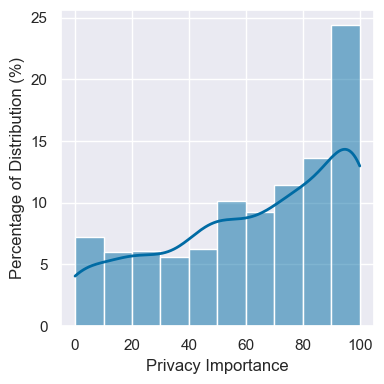

Correlation between Privacy Importance and Worry about Info: 0.30693315961133294


In [6]:
# Privacy Importance and Worry about it
ax = sns.histplot(data=df, x='Privacy Importance', kde=True, stat='percent', bins=10)
ax.set(xlabel='Privacy Importance', ylabel='Percentage of Distribution (%)')
plt.savefig('figures/01_privacy.png', bbox_inches='tight')
plt.savefig('figures/01_privacy.pdf', bbox_inches='tight')
plt.show()
correlation_spearman = df.select(pl.corr('Privacy Importance', 'Worry about Info', method='spearman'))
print(f'Correlation between Privacy Importance and Worry about Info: {pl.select(correlation_spearman).item()}')

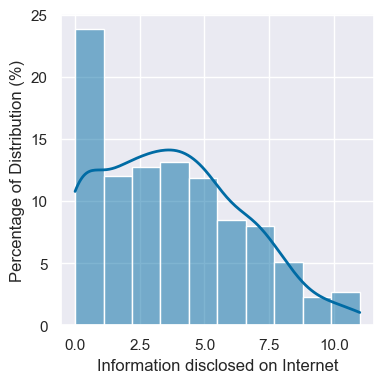

In [7]:
ax = sns.histplot(data=df, x='Info on Internet', kde=True, stat='percent', bins=10)
ax.set(xlabel='Information disclosed on Internet', ylabel='Percentage of Distribution (%)')
plt.savefig('figures/02_info.png', bbox_inches='tight')
plt.savefig('figures/02_info.pdf', bbox_inches='tight')
plt.show()

In [8]:
correlation_spearman = df.select(pl.corr('Privacy Importance', 'Info on Internet', method='spearman'))
print(f'Correlation between Privacy Importance and Info on Internet: {pl.select(correlation_spearman).item()}')

Correlation between Privacy Importance and Info on Internet: -0.014508784067549435


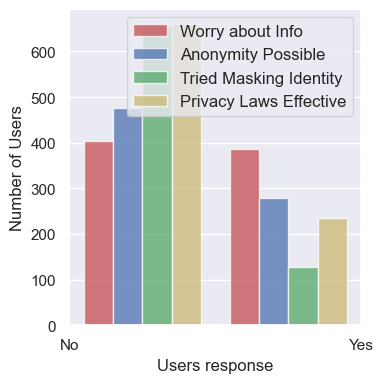

In [9]:
plt.hist(df[['Worry about Info','Anonymity Possible', 'Tried Masking Identity', 'Privacy Laws Effective']], 
color=['r','b', 'g', 'y'], histtype='bar', bins=2, alpha=0.75,
label=['Worry about Info','Anonymity Possible', 'Tried Masking Identity', 'Privacy Laws Effective'])
plt.legend(prop={'size': 12})
plt.xticks([0, 1], ['No', 'Yes'])
plt.ylabel('Number of Users')
plt.xlabel('Users response')

plt.savefig('figures/03_status.png', bbox_inches='tight')
plt.savefig('figures/03_status.pdf', bbox_inches='tight')
plt.show()

## Info on Internet Prediction

### Fill in missing values

In [10]:
df_final = fill_in_missing_values(df)

0.17006407609832203 / (0.6, 5, 15)


In [11]:
df_final.describe()

statistic,Sex,Age,State,Region,Conservativeness,Internet,Smartphone,Info on Internet,Worry about Info,Privacy Importance,Anonymity Possible,Tried Masking Identity,Privacy Laws Effective
str,str,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1002""",1002.0,"""1002""","""1002""",1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0
"""null_count""","""0""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,52.441118,null,null,3.259481,0.773453,0.49501,0.273824,0.38523,0.498837,0.300399,0.130739,0.271457
"""std""",null,18.349505,null,null,0.982634,0.418806,0.500225,0.258353,0.486893,0.37429,0.458661,0.337283,0.444933
"""min""","""Female""",18.0,"""Alabama""","""Midwest""",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",null,38.0,null,null,3.0,1.0,0.0,9.0065e-16,0.0,0.074386,0.0,0.0,0.0
"""50%""",null,55.0,null,null,3.0,1.0,0.0,0.272727,0.0,0.555556,0.0,0.0,0.0
"""75%""",null,66.0,null,null,4.0,1.0,1.0,0.454545,1.0,0.857143,1.0,0.0,1.0
"""max""","""Male""",96.0,"""Wyoming""","""West""",5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Try 3 different models

In [12]:
from sklearn.pipeline import Pipeline

from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)

models = [('Linear Regression', LinearRegression(), {}),
('MLP', MLPRegressor(random_state=42, max_iter=1000), 
{'hidden_layer_sizes':[(4,),(8,),(16,),(32,)], 'learning_rate':['constant', 'invscaling', 'adaptive'],
'learning_rate_init':[0.1,0.01,0.001,0.0001]}),
('K Neighbors', KNeighborsRegressor(),{'n_neighbors':[1,3,5,7,9], 
'weights':['uniform', 'distance'], 'p':[1,2]}),
('Random Forest', RandomForestRegressor(random_state=42),{'n_estimators':[50, 100, 150, 200],
'min_samples_split':[2, 5, 10],'min_samples_leaf':[1, 2, 4], 'bootstrap':[True, False], 'max_depth':max_depth})]

In [13]:
df_predict = df_final[['Internet', 'Smartphone', 'Info on Internet', 'Privacy Importance', 
'Worry about Info', 'Anonymity Possible', 'Tried Masking Identity', 'Privacy Laws Effective']]

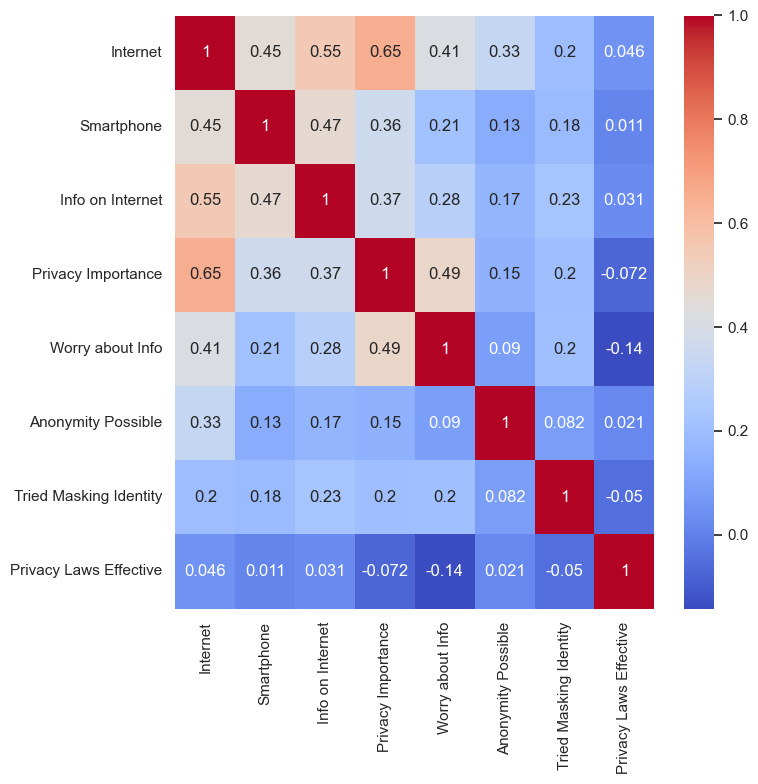

In [14]:
labels = ['Internet', 'Smartphone', 'Info on Internet', 'Privacy Importance', 
'Worry about Info', 'Anonymity Possible', 'Tried Masking Identity', 'Privacy Laws Effective']
plt.figure(figsize=(8,8))
sns.heatmap(df_predict.corr(),  xticklabels=labels, yticklabels=labels, cmap='coolwarm', annot=True)
plt.savefig('figures/06_corr.png', bbox_inches='tight')
plt.savefig('figures/06_corr.pdf', bbox_inches='tight')
plt.show()

In [15]:
y = df_predict[['Info on Internet']].to_numpy().ravel()
X = df_predict.drop(['Info on Internet'])

In [16]:
X_train, X_test, y_train, y_test = train_test_split_regression(X, y, test_size=0.3, b='auto', random_state=42)

In [17]:
# Create the folds for grid search
folds = create_folds_regression(X_train, y_train, b='auto', k=3)
folds_list = [(train_index, test_index) for train_index, test_index in folds]  

preds_train = []
preds_test = []

for name, model, params in models:
    print(f'Model: {name}')
    reg = model_selection.GridSearchCV(model, params, cv=folds_list, scoring='r2', n_jobs=-1)
    reg.fit(X_train, y_train)
        
    y_preds_train = reg.predict(X_train)
    preds_train.append((name, y_preds_train))
    y_preds_test  = reg.predict(X_test)
    preds_test.append((name, y_preds_test))

    print(f'Results from train:')
    regression_results(y_train, y_preds_train)
    print(f'Results from test:')
    regression_results(y_test, y_preds_test)
    print(f'-------------------------------------')

Model: Linear Regression


Results from train:
EV   : 0.3899
R2   : 0.3899
MAE  : 0.1481
MSE  : 0.0406
RMSE : 0.2014
SMAPE: 88.2956
Results from test:
EV   : 0.3343
R2   : 0.3331
MAE  : 0.1564
MSE  : 0.0447
RMSE : 0.2115
SMAPE: 94.3398
-------------------------------------
Model: MLP
Results from train:
EV   : 0.3924
R2   : 0.3919
MAE  : 0.1476
MSE  : 0.0404
RMSE : 0.2011
SMAPE: 85.0602
Results from test:
EV   : 0.3408
R2   : 0.3376
MAE  : 0.156
MSE  : 0.0444
RMSE : 0.2108
SMAPE: 93.0795
-------------------------------------
Model: K Neighbors
Results from train:
EV   : 0.4381
R2   : 0.4378
MAE  : 0.1399
MSE  : 0.0374
RMSE : 0.1934
SMAPE: 52.021
Results from test:
EV   : 0.2676
R2   : 0.2643
MAE  : 0.162
MSE  : 0.0493
RMSE : 0.2221
SMAPE: 57.9707
-------------------------------------
Model: Random Forest
Results from train:
EV   : 0.538
R2   : 0.538
MAE  : 0.1252
MSE  : 0.0307
RMSE : 0.1753
SMAPE: 79.7589
Results from test:
EV   : 0.2803
R2   : 0.2786
MAE  : 0.1608
MSE  : 0.0484
RMSE : 0.2199
SMAPE: 95.4405
----

In [18]:
labels = [name for name, _ in preds_train]
diff_train = [np.abs(y_preds_train - y_train) for _, y_preds_train in preds_train]
diff_test  = [np.abs(y_preds_test - y_test) for _, y_preds_test in preds_test]

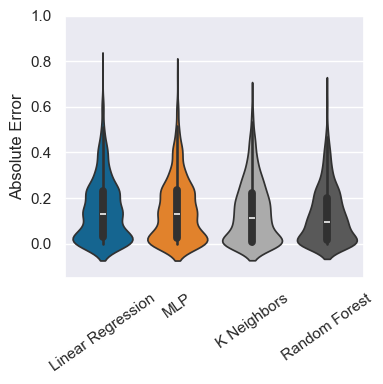

In [19]:
ax = sns.violinplot(data=diff_train)
ax.xaxis.set_ticks([0,1,2,3])
ax.set_xticklabels(labels)
ax.set(ylim=(-0.15, 1.0))
ax.set(ylabel='Absolute Error')
plt.xticks(rotation=35)
plt.savefig('figures/04_diff_train.png', bbox_inches='tight')
plt.savefig('figures/04_diff_train.pdf', bbox_inches='tight')
plt.show()

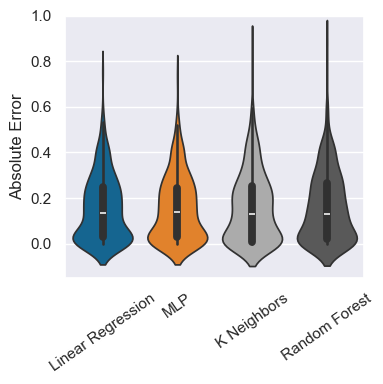

In [20]:
ax = sns.violinplot(data=diff_test)
ax.xaxis.set_ticks([0,1,2,3])
ax.set_xticklabels(labels)
ax.set(ylim=(-0.15, 1.0))
ax.set(ylabel='Absolute Error')
plt.xticks(rotation=35)
plt.savefig('figures/05_diff_test.png', bbox_inches='tight')
plt.savefig('figures/05_diff_test.pdf', bbox_inches='tight')
plt.show()